# Assignment 2 Part Ⅱ

# Task 0: Preparation

## Packages

In [5]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np

import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.special as scps
from statsmodels.graphics.gofplots import qqplot
from scipy.linalg import cholesky
from functools import partial
#from FMNM.probabilities import Heston_pdf, Q1, Q2
#from FMNM.cython.heston import Heston_paths_log, Heston_paths
from scipy.optimize import minimize
#from FMNM.BS_pricer import BS_pricer
#from FMNM.Parameters import Option_param
#from FMNM.Processes import Diffusion_process
from IPython.display import display
import sympy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.optimize import minimize
from scipy.optimize import brentq
from scipy.stats import norm
from scipy.special import gamma as gamma_func
import math
from tqdm import tqdm

sympy.init_printing()


def display_matrix(m):
    display(sympy.Matrix(m))

In [7]:
import matplotlib.pyplot as plt
import scipy.special as scps
from statsmodels.graphics.gofplots import qqplot
from scipy.linalg import cholesky
from functools import partial
#from FMNM.probabilities import Heston_pdf, Q1, Q2
#from FMNM.cython.heston import Heston_paths_log, Heston_paths
from scipy.optimize import minimize

from IPython.display import display
import sympy

sympy.init_printing()


def display_matrix(m):
    display(sympy.Matrix(m))

# Task 1: Monte Carlo Simulation under Heston Model

### Simulate X and Y paths

In [13]:
%%time
np.random.seed(seed=42)

N = 10000  # time steps
paths = 10000  # number of paths
T = 1
T_vec, dt = np.linspace(0, T, N, retstep=True)
dt_sq = np.sqrt(dt)

S0 = 100  # spot price
X0 = np.log(S0)  # log price
v0 = 0.04  # spot variance

mu = 0.1  # drift
rho = -0.2  # correlation coefficient
kappa = 2  # mean reversion coefficient
theta = 0.04  # long-term variance
sigma = 0.3  # Vol of Vol - Volatility of instantaneous variance
std_asy = np.sqrt(theta * sigma**2 / (2 * kappa))  # asymptotic standard deviation for the CIR process
assert 2 * kappa * theta > sigma**2  # Feller condition

# Generate random Brownian Motion
MU = np.array([0, 0])
COV = np.matrix([[1, rho], [rho, 1]])
W = ss.multivariate_normal.rvs(mean=MU, cov=COV, size=(N - 1, paths))
W_S = W[:, :, 0]  # Stock Brownian motion:     W_1
W_v = W[:, :, 1]  # Variance Brownian motion:  W_2

# Initialize vectors
V = np.zeros((N, paths))
V[0, :] = v0
Y = np.zeros((N, paths))
Y[0, :] = np.log(v0)

X = np.zeros((N, paths))
X[0, :] = X0
v = np.zeros(N)

# Generate paths with progress bar
for t in tqdm(range(0, N - 1), desc="Simulating paths"):
    v = V[t, :]  # variance
    v_exp = np.exp(Y[t, :])
    v_sq = np.sqrt(v)  # square root of variance
    v_sq_exp = np.sqrt(v_exp)
    
    V[t + 1, :] = (
        np.abs(V[t, :] + kappa * (theta - v) * dt + sigma * v_sq * dt_sq * W_v[t, :])
    )

    Y[t + 1, :] = (
        Y[t, :] + (1 / v_exp) * (kappa * (theta - v_exp) - 0.5 * sigma**2) * dt
        + sigma * (1 / v_sq_exp) * dt_sq * W_v[t, :]
    )

    X[t + 1, :] = X[t, :] + (mu - 0.5 * v) * dt + v_sq * dt_sq * W_S[t, :]


Simulating paths: 100%|██████████████████████████████████████████████████████████| 9999/9999 [00:03<00:00, 2679.67it/s]


CPU times: total: 10.6 s
Wall time: 9.54 s


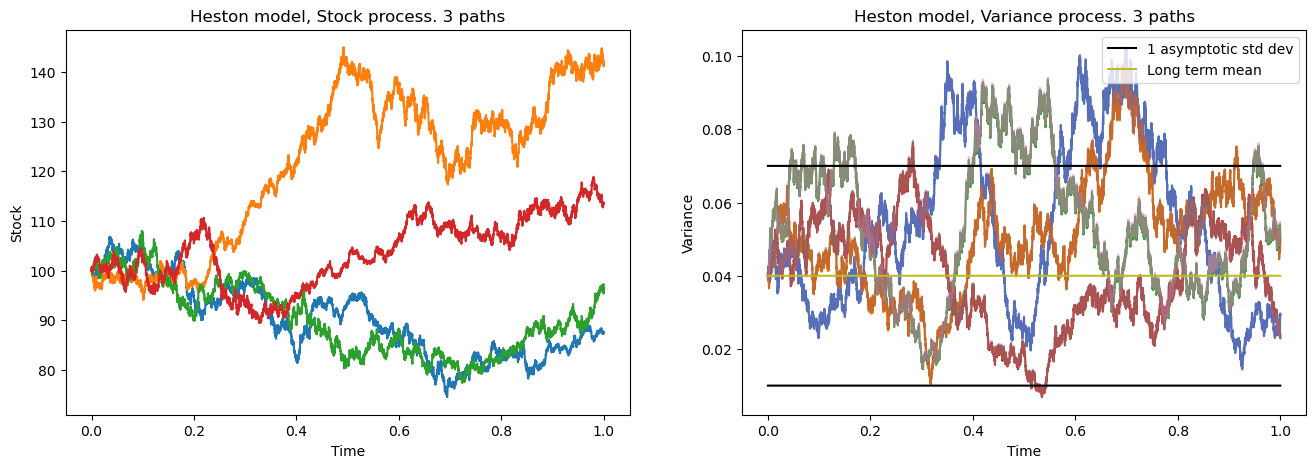

In [14]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# ax3 = fig.add_subplot(123)

ax1.plot(T_vec, np.exp(X)[:,0:4])
ax1.set_title("Heston model, Stock process. 3 paths")
ax1.set_xlabel("Time")
ax1.set_ylabel("Stock")
ax2.plot(T_vec, np.exp(Y[:,0:4]))
# ax3.plot(T_vec, np.exp(Y[:,0:4]))
ax2.plot(T_vec, V[:,0:4],alpha = 0.5)
ax2.set_title("Heston model, Variance process. 3 paths")
ax2.set_xlabel("Time")
ax2.set_ylabel("Variance")
ax2.plot(T_vec, (theta + std_asy) * np.ones_like(T_vec), label="1 asymptotic std dev", color="black")
ax2.plot(T_vec, (theta - std_asy) * np.ones_like(T_vec), color="black")
ax2.plot(T_vec, theta * np.ones_like(T_vec), label="Long term mean")
ax2.legend(loc="upper right")
plt.show()

## Step 1: Simulate S and v paths

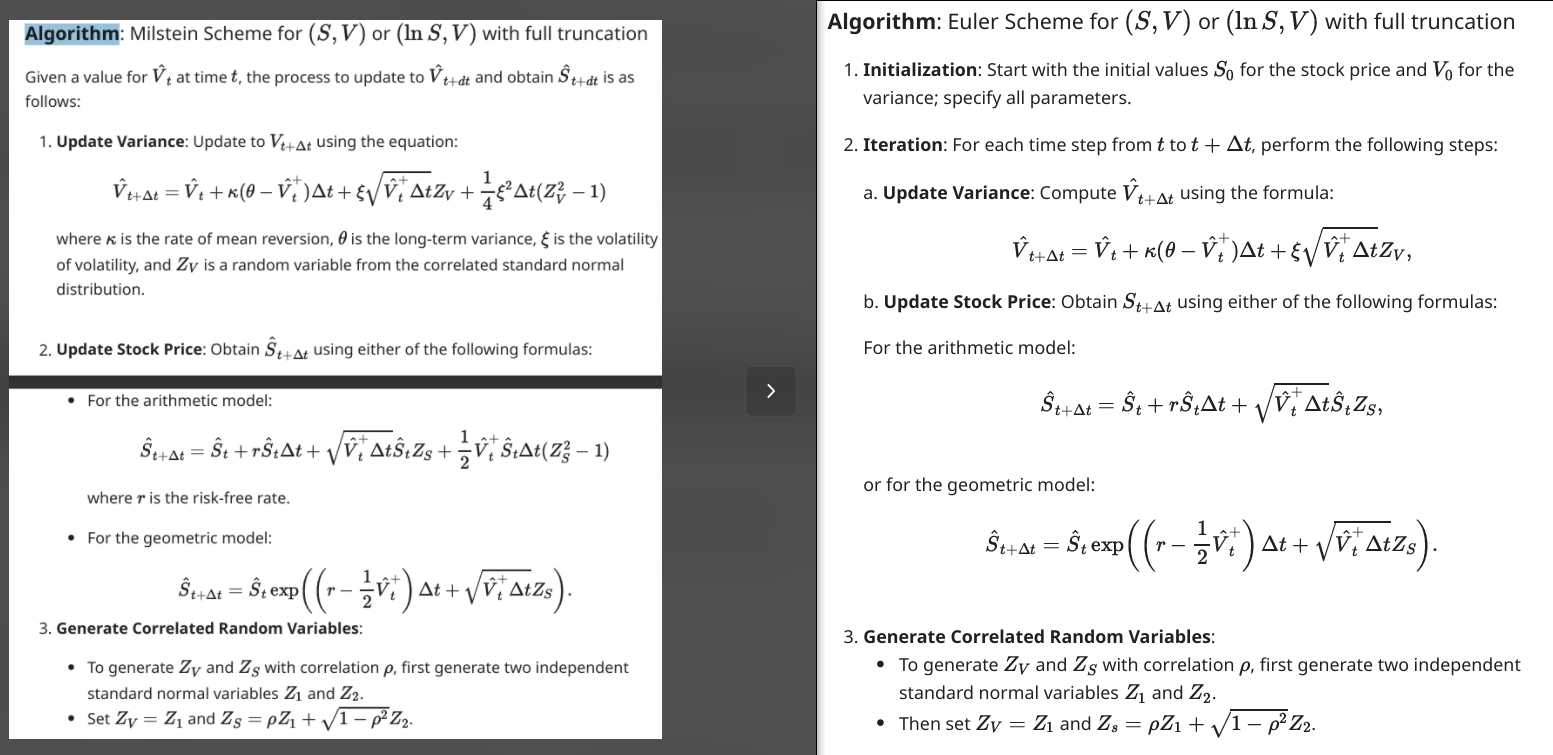

In [25]:
%%time
np.random.seed(seed=42)

N = 10000  # time steps
M = 10000  # number of paths
T = 1
T_vec, dt = np.linspace(0, T, N, retstep=True)
dt_sq = np.sqrt(dt)

S0 = 100  # spot price
X0 = np.log(S0)  # log price
v0 = 0.04  # spot variance

r = 0.05
mu = 0.1  # drift
rho = -0.2  # correlation coefficient
kappa = 2  # mean reversion coefficient
theta = 0.04  # long-term variance
xi = 0.3  # Vol of Vol - Volatility of instantaneous variance
std_asy = np.sqrt(theta * xi**2 / (2 * kappa))  # asymptotic standard deviation for the CIR process
assert 2 * kappa * theta > xi**2  # Feller condition

# Generate random Brownian Motion
MU = np.array([0, 0])
COV = np.matrix([[1, rho], [rho, 1]])
Z = ss.multivariate_normal.rvs(mean=MU, cov=COV, size=(N - 1, M))
Z_S = Z[:, :, 0]  # Stock Brownian motion:     W_1
Z_V = Z[:, :, 1]  # Variance Brownian motion:  W_2

# Initialize vectors
S_euler = np.zeros((N, M))
V_euler = np.zeros((N, M))
S_milstein = np.zeros((N, M))
V_milstein = np.zeros((N, M))

S_euler[0, :] = S0
V_euler[0, :] = v0
S_milstein[0, :] = S0
V_milstein[0, :] = v0

v = np.zeros(N)

# Generate paths with progress bar
for t in tqdm(range(0, N - 1), desc="Simulating paths"):
    # Euler:
    Vt_e = np.maximum(V_euler[t, :], 0)
    sqrt_V_e = np.sqrt(Vt_e)

    V_euler[t + 1, :] = V_euler[t, :] + kappa * (theta - Vt_e) * dt + xi * sqrt_V_e * dt_sq * Z_V[t, :]
    V_euler[t + 1, :] = np.abs(V_euler[t + 1, :])

    S_euler[t + 1, :] = S_euler[t, :] + r * S_euler[t, :] * dt + sqrt_V_e * dt_sq * S_euler[t, :] * Z_S[t, :]

    # Milstein:
    Vt_m = np.maximum(V_milstein[t, :], 0)
    sqrt_V_m = np.sqrt(Vt_m)

    V_milstein[t + 1, :] = V_milstein[t, :] + kappa * (theta - Vt_m) * dt + xi * sqrt_V_m * dt_sq * Z_V[t, :] + 0.25 * xi**2 * dt * (Z_V[t, :]**2 - 1)
    V_milstein[t + 1, :] = np.abs(V_milstein[t + 1, :])

    S_milstein[t + 1, :] = S_milstein[t, :] + r * S_milstein[t, :] * dt + sqrt_V_m * dt_sq * S_milstein[t, :] * Z_S[t, :] + 0.5 * Vt_m * S_milstein[t, :] * dt * (Z_S[t, :]**2 - 1)

Simulating paths: 100%|██████████████████████████████████████████████████████████| 9999/9999 [00:04<00:00, 2159.42it/s]


CPU times: total: 12.5 s
Wall time: 11.4 s


### Plot Stock Prices Paths

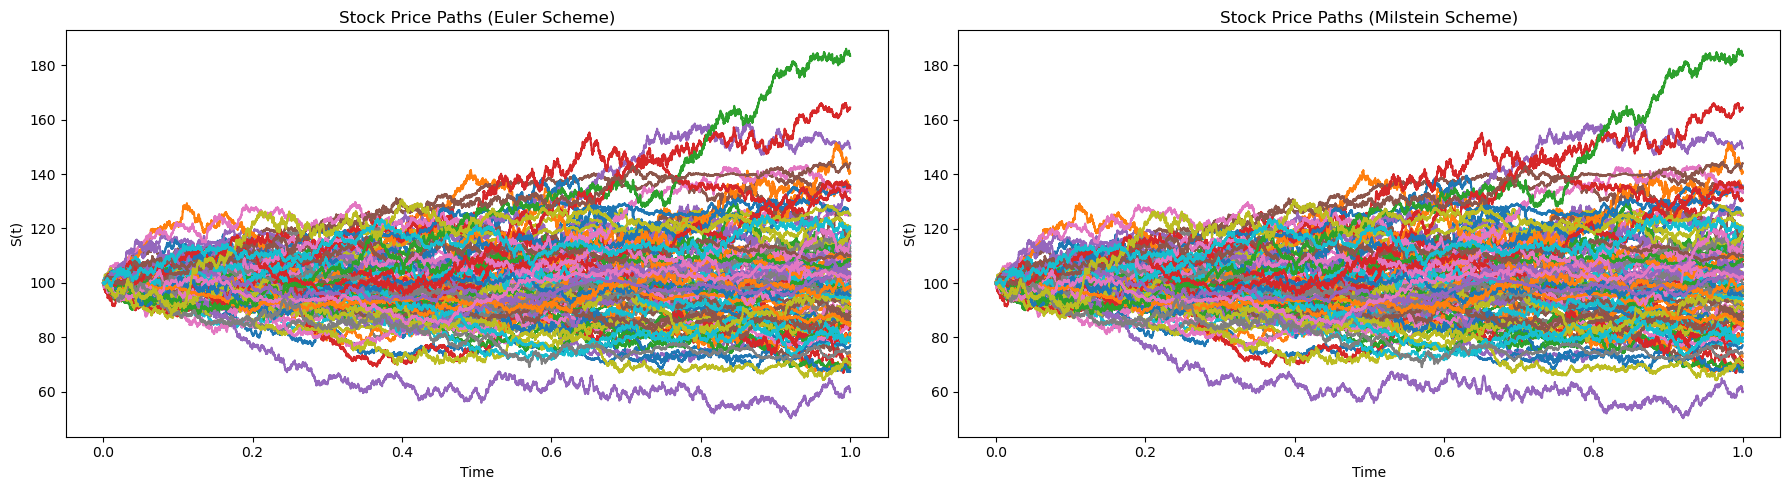

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1.plot(T_vec, S_euler[:, :100])
ax1.set_title("Stock Price Paths (Euler Scheme)")
ax1.set_xlabel("Time")
ax1.set_ylabel("S(t)")

ax2.plot(T_vec, S_milstein[:, :100])
ax2.set_title("Stock Price Paths (Milstein Scheme)")
ax2.set_xlabel("Time")
ax2.set_ylabel("S(t)")

plt.tight_layout()
plt.show()

In [21]:
np.max(S_euler-S_milstein)

### Plot Variance Paths

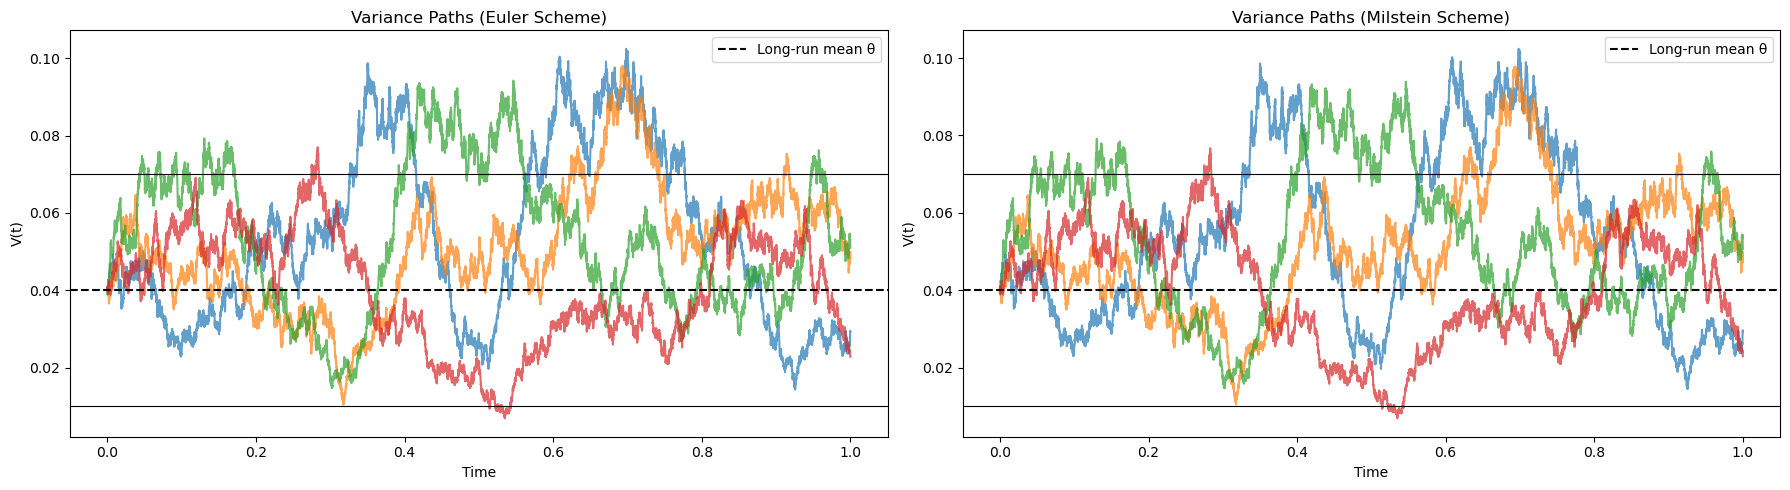

In [23]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(18, 5))

ax3.plot(T_vec, V_euler[:, :4], alpha=0.7)
ax3.set_title("Variance Paths (Euler Scheme)")
ax3.set_xlabel("Time")
ax3.set_ylabel("V(t)")
ax3.axhline(theta, color="black", linestyle="--", label="Long-run mean θ")
ax3.axhline(theta + std_asy, color="black", linewidth=0.8)
ax3.axhline(theta - std_asy, color="black", linewidth=0.8)
ax3.legend()

ax4.plot(T_vec, V_milstein[:, :4], alpha=0.7)
ax4.set_title("Variance Paths (Milstein Scheme)")
ax4.set_xlabel("Time")
ax4.set_ylabel("V(t)")
ax4.axhline(theta, color="black", linestyle="--", label="Long-run mean θ")
ax4.axhline(theta + std_asy, color="black", linewidth=0.8)
ax4.axhline(theta - std_asy, color="black", linewidth=0.8)
ax4.legend()

plt.tight_layout()
plt.show()

In [24]:
np.max(V_euler-V_milstein)

## Step2: Calculate the arithmetic average price along each path and the corresponding option payoff.

In [36]:
K = 100
avg_price_euler = np.mean(S_euler[:, 1:], axis=1)
avg_price_milstein = np.mean(S_milstein[:, 1:], axis=1)
payoff_euler = np.maximum(avg_price_euler - K, 0)
payoff_milstein = np.maximum(avg_price_milstein - K, 0)

## Step3: Compute the Monte Carlo estimator and its standard error using M simulated paths. Compare Euler versus Milstein scheme

In [37]:
price_euler = np.exp(-r * T) * np.mean(payoff_euler)
std_euler = np.std(np.exp(-r * T) * payoff_euler) / np.sqrt(M)

price_milstein = np.exp(-r * T) * np.mean(payoff_milstein)
std_milstein = np.std(np.exp(-r * T) * payoff_milstein) / np.sqrt(M)

## Step4: Verify your implementation by temporarily setting volatility-of-volatility ξ = 0 (reducing Heston to GBM) and comparing your results against known or approximated benchmarks

In [38]:
%%time
np.random.seed(seed=42)

xi = 0  # Vol of Vol - Volatility of instantaneous variance

S_euler_null = np.zeros((N, M))
V_euler_null = np.zeros((N, M))
S_milstein_null = np.zeros((N, M))
V_milstein_null = np.zeros((N, M))

S_euler_null[0, :] = S0
V_euler_null[0, :] = v0
S_milstein_null[0, :] = S0
V_milstein_null[0, :] = v0

for t in tqdm(range(0, N - 1), desc="Simulating paths"):
    # Euler:
    Vt_e = np.maximum(V_euler_null[t, :], 0)
    sqrt_V_e = np.sqrt(Vt_e)

    V_euler_null[t + 1, :] = V_euler_null[t, :] + kappa * (theta - Vt_e) * dt + xi * sqrt_V_e * dt_sq * Z_V[t, :]
    V_euler_null[t + 1, :] = np.abs(V_euler_null[t + 1, :])

    S_euler_null[t + 1, :] = S_euler_null[t, :] + r * S_euler_null[t, :] * dt + sqrt_V_e * dt_sq * S_euler_null[t, :] * Z_S[t, :]

    # Milstein:
    Vt_m = np.maximum(V_milstein_null[t, :], 0)
    sqrt_V_m = np.sqrt(Vt_m)

    V_milstein_null[t + 1, :] = V_milstein_null[t, :] + kappa * (theta - Vt_m) * dt + xi * sqrt_V_m * dt_sq * Z_V[t, :] + 0.25 * xi**2 * dt * (Z_V[t, :]**2 - 1)
    V_milstein_null[t + 1, :] = np.abs(V_milstein_null[t + 1, :])

    S_milstein_null[t + 1, :] = S_milstein_null[t, :] + r * S_milstein_null[t, :] * dt + sqrt_V_m * dt_sq * S_milstein_null[t, :] * Z_S[t, :] + 0.5 * Vt_m * S_milstein_null[t, :] * dt * (Z_S[t, :]**2 - 1)

Simulating paths: 100%|███████████████████████████████████████████████████████████| 9999/9999 [00:15<00:00, 663.73it/s]

CPU times: total: 6.22 s
Wall time: 15.1 s


In [39]:
avg_price_euler_null = np.mean(S_euler_null[:, 1:], axis=1)
avg_price_milstein_null = np.mean(S_milstein_null[:, 1:], axis=1)
payoff_euler_null = np.maximum(avg_price_euler_null - K, 0)
payoff_milstein_null = np.maximum(avg_price_milstein_null - K, 0)

price_euler_null = np.exp(-r * T) * np.mean(payoff_euler_null)
std_euler_null = np.std(np.exp(-r * T) * payoff_euler_null) / np.sqrt(M)
price_milstein_null = np.exp(-r * T) * np.mean(payoff_milstein_null)
std_milstein_null = np.std(np.exp(-r * T) * payoff_milstein_null) / np.sqrt(M)

## TASK1 RESULTS:

In [40]:
df = pd.DataFrame([
        {"Method": "Euler (Heston)", "Price": price_euler, "Std Error": std_euler},
        {"Method": "Milstein (Heston)", "Price": price_milstein, "Std Error": std_milstein},
        {"Method": "Euler (GBM, ξ=0)", "Price": price_euler_null, "Std Error": std_euler_null},
        {"Method": "Milstein (GBM, ξ=0)", "Price": price_milstein_null, "Std Error": std_milstein_null}
    ])
print(df)

                Method     Price  Std Error
0       Euler (Heston)  2.270973   0.013178
1    Milstein (Heston)  2.271558   0.013181
2     Euler (GBM, ξ=0)  2.260901   0.013031
3  Milstein (GBM, ξ=0)  2.261387   0.013033


# Task 2: Analytical Geometric-Asian Price as Control Variate Reference

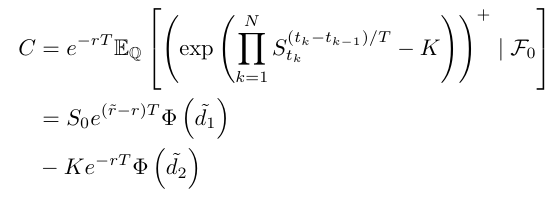
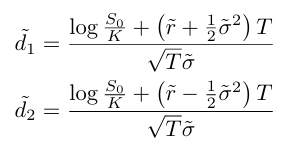
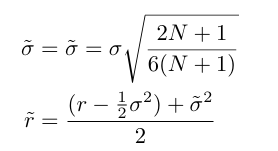

## Step1: Choose and justify a suitable volatility σ for the GBM control variate.

In [64]:
sigma = theta

## Step2: Calculate the geometric Asian option price analytically using the provided closed-form solution.

In [63]:
sigma_sq = sigma**2
sigma_tilde = sigma * np.sqrt((2 * N + 1) / (6 * (N + 1)))
r_tilde = 0.5 * (r - 0.5 * sigma_sq + 0.5 * sigma_tilde**2)

d1 = (np.log(S0 / K) + (r_tilde + 0.5 * sigma_tilde**2) * T) / (sigma_tilde * np.sqrt(T))
d2 = d1 - sigma_tilde * np.sqrt(T)
price = S0 * np.exp((r_tilde - r) * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
print(price)

2.5436020112754107


## Step3: Test your implementation on known scenarios to ensure accuracy

# Task 3: Implementing the Control Variate Monte Carlo

## Step1: Simulate parallel Black–Scholes (GBM) paths using identical Brownian increments from the Heston paths.

## Step2: Compute arithmetic-average Asian payoffs (Heston) and geometric-average Asian payoffs (GBM) simultaneously.

In [65]:
log_S_gbm_euler = np.log(S_euler_null[1:, :])
geo_avg_gbm_euler = np.exp(np.mean(log_S_gbm_euler, axis=0))
payoff_gbm_geo_euler = np.maximum(geo_avg_gbm_euler - K, 0)

log_S_gbm_milstein = np.log(S_milstein_null[1:, :])
geo_avg_gbm_milstein = np.exp(np.mean(log_S_gbm_milstein, axis=0))
payoff_gbm_geo_milstein = np.maximum(geo_avg_gbm_milstein - K, 0)

## Step3: Use the control variate estimator with initially choosing c = 1.

In [66]:
Y_bar_euler = np.mean(payoff_euler)
Y_bar_milstein = np.mean(payoff_milstein)
X_bar_euler = np.mean(payoff_gbm_geo_euler)
X_bar_milstein = np.mean(payoff_gbm_geo_milstein)
C_G = price
c = 1
C_CV1 = Y_bar_euler + c * (C_G - X_bar_euler)
C_CV2 = Y_bar_milstein + c * (C_G - X_bar_milstein)
print(C_CV1,C_CV2)

-0.7795879492897115 -0.7791420676850307


In [68]:
X_bar_euler

## Step4: Compute variance and standard error of both the plain and control variate estimators, and compare their performance

In [60]:
var_cv1 = np.var(np.exp(-r * T) * (payoff_euler + c * (C_G - payoff_gbm_geo_euler))) / M
var_cv2 = np.var(np.exp(-r * T) * (payoff_milstein + c * (C_G - payoff_gbm_geo_milstein))) / M
print(var_cv1,var_cv2)

std_cv1 = np.std(np.exp(-r * T) * (payoff_euler + c * (C_G - payoff_gbm_geo_euler))) / np.sqrt(M)
std_cv2 = np.std(np.exp(-r * T) * (payoff_milstein + c * (C_G - payoff_gbm_geo_milstein))) / np.sqrt(M)
print(std_cv1,std_cv2)

0.0059425269078938175 0.005942816228349573
0.07708778702164057 0.07708966356360347


In [55]:
df_2 = pd.DataFrame([
        {"Method": "Euler (Heston)", "Price": price_euler, "Std Error": std_euler},
        {"Method": "Milstein (Heston)", "Price": price_milstein, "Std Error": std_milstein},
        {"Method": "Control Variate-Euler", "Price": np.exp(-r * T) * C_CV1, "Std Error": std_cv1},
        {"Method": "Control Variate-Milstein", "Price": np.exp(-r * T) * C_CV2, "Std Error": std_cv2}
    ])
print(df_2)

                     Method     Price  Std Error
0            Euler (Heston)  2.270973   0.013178
1         Milstein (Heston)  2.271558   0.013181
2     Control Variate-Euler  1.933116   0.077088
3  Control Variate-Milstein  1.933702   0.077088


# Task 4: Experiments and Comparative Analysis

## (a): Variance Reduction Efficacy

In [ ]:
def MC(M_values, xi, rho, K):
    results = []
    # Step1: Simulation: Euler;Milstein;GBM
    for t in tqdm(range(0, N - 1), desc="Simulating paths"):
        # Euler:
        Vt_e = np.maximum(V_euler[t, :], 0)
        sqrt_V_e = np.sqrt(Vt_e)
        V_euler[t + 1, :] = V_euler[t, :] + kappa * (theta - Vt_e) * dt + xi * sqrt_V_e * dt_sq * Z_V[t, :]
        V_euler[t + 1, :] = np.abs(V_euler[t + 1, :])
        S_euler[t + 1, :] = S_euler[t, :] + r * S_euler[t, :] * dt + sqrt_V_e * dt_sq * S_euler[t, :] * Z_S[t, :]
    
        # Milstein:
        Vt_m = np.maximum(V_milstein[t, :], 0)
        sqrt_V_m = np.sqrt(Vt_m)
        V_milstein[t + 1, :] = V_milstein[t, :] + kappa * (theta - Vt_m) * dt + xi * sqrt_V_m * dt_sq * Z_V[t, :] + 0.25 * xi**2 * dt * (Z_V[t, :]**2 - 1)
        V_milstein[t + 1, :] = np.abs(V_milstein[t + 1, :])
        S_milstein[t + 1, :] = S_milstein[t, :] + r * S_milstein[t, :] * dt + sqrt_V_m * dt_sq * S_milstein[t, :] * Z_S[t, :] + 0.5 * Vt_m * S_milstein[t, :] * dt * (Z_S[t, :]**2 - 1)
    
        # GBM:
        V_euler_null[t + 1, :] = V_euler_null[t, :] + kappa * (theta - Vt_e) * dt
        V_euler_null[t + 1, :] = np.abs(V_euler_null[t + 1, :])
        S_euler_null[t + 1, :] = S_euler_null[t, :] + r * S_euler_null[t, :] * dt + sqrt_V_e * dt_sq * S_euler_null[t, :] * Z_S[t, :]
    
        V_milstein_null[t + 1, :] = V_milstein_null[t, :] + kappa * (theta - Vt_m) * dt
        V_milstein_null[t + 1, :] = np.abs(V_milstein_null[t + 1, :])
        S_milstein_null[t + 1, :] = S_milstein_null[t, :] + r * S_milstein_null[t, :] * dt + sqrt_V_m * dt_sq * S_milstein_null[t, :] * Z_S[t, :] + 0.5 * Vt_m * S_milstein_null[t, :] * dt * (Z_S[t, :]**2 - 1)


    # Step2: Compute arithmetic Prices and Payoffs
    avg_price_euler = np.mean(S_euler[:, 1:], axis=1)
    avg_price_milstein = np.mean(S_milstein[:, 1:], axis=1)
    payoff_euler = np.maximum(avg_price_euler - K, 0)
    payoff_milstein = np.maximum(avg_price_milstein - K, 0)


    # Step3: Compute rude MC estimator:
    price_euler_rMC = np.exp(-r * T) * np.mean(payoff_euler)
    std_euler_rMC = np.std(np.exp(-r * T) * payoff_euler) / np.sqrt(M)
    
    price_milstein_rMC = np.exp(-r * T) * np.mean(payoff_milstein)
    std_milstein_rMC = np.std(np.exp(-r * T) * payoff_milstein) / np.sqrt(M)


    # Step4: Compute geometric Prices and Payoffs
    sigma = np.sqrt(theta)
    sigma_sq = sigma**2
    sigma_tilde = sigma * np.sqrt((2 * N + 1) / (6 * (N + 1)))
    r_tilde = 0.5 * (r - 0.5 * sigma_sq + 0.5 * sigma_tilde**2)
    
    d1 = (np.log(S0 / K) + (r_tilde + 0.5 * sigma_tilde**2) * T) / (sigma_tilde * np.sqrt(T))
    d2 = d1 - sigma_tilde * np.sqrt(T)
    price_geo = S0 * np.exp((r_tilde - r) * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    log_S_gbm_euler = np.log(S_euler_null[1:, :])
    geo_avg_gbm_euler = np.exp(np.mean(log_S_gbm_euler, axis=0))
    payoff_gbm_geo_euler = np.maximum(geo_avg_gbm_euler - K, 0)
    
    log_S_gbm_milstein = np.log(S_milstein_null[1:, :])
    geo_avg_gbm_milstein = np.exp(np.mean(log_S_gbm_milstein, axis=0))
    payoff_gbm_geo_milstein = np.maximum(geo_avg_gbm_milstein - K, 0)
    
    
    # Step5: Compute control variate MC:
    Y_bar_euler = np.mean(payoff_euler)
    Y_bar_milstein = np.mean(payoff_milstein)
    X_bar_euler = np.mean(payoff_gbm_geo_euler)
    X_bar_milstein = np.mean(payoff_gbm_geo_milstein)
    C_G = price
    c = 1
    
    price_euler_cvMC = np.exp(-r * T) * (Y_bar_euler + c * (C_G - X_bar_euler))
    std_euler_cvMC = np.std(np.exp(-r * T) * (payoff_euler + c * (C_G - payoff_gbm_geo_euler))) / np.sqrt(M)
    
    price_milstein_cvMC = np.exp(-r * T) * (Y_bar_milstein + c * (C_G - X_bar_milstein))
    std_milstein_cvMC = np.std(np.exp(-r * T) * (payoff_milstein + c * (C_G - payoff_gbm_geo_milstein))) / np.sqrt(M)


    # Step6: Print results:
    results = pd.DataFrame([
        {"Method": "Rude MC estimator-Euler (Heston)", "Price": price_euler_rMC, "Std Error": std_euler_rMCer},
        {"Method": "Rude MC estimator-Milstein (Heston)", "Price": price_milstein_rMCn, "Std Error": std_milstein_rMCn},
        {"Method": "Control Variate MC estimator-Euler", "Price": price_euler_cvMC, "Std Error": std_euler_cvMC},
        {"Method": "Control Variate MC estimator-Milstein", "Price": price_milstein_cvMC, "Std Error": std_milstein_cvMC}
    ])
    
    return results

## (b): Impact of Varying Heston Parameters: 

## (c): Additional Analysis